In [1]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch

from dataset_creation.noisy_dataset import create_single_noisy_version
from dataset_creation.utils import get_n_random_noises

# Create a Noisy Dataset

## Requirements And Configuration

The generated noisy traces should be a synthetic version of traces taken from the following dataset ('ethz', 'geofon'):

In [2]:
DATASETS_ORIGINS = ['ethz', 'geofon']
dataset_origin = 'ethz'
assert dataset_origin in DATASETS_ORIGINS, f'Expected dataset one of {DATASETS_ORIGINS}. Got {dataset_origin}.'

In [3]:
NUM_SAMPLES=3001                    # Trace sample length - If the dataset is built for phasenet: 3001 If it is for EQTransformer: 6000
NUM_NOISY_VERSIONS_PER_TRACE=1      # How many noisy versions to synthesize using a single real trace
DESIRED_SNR=10                      # What SNR level should the noisy synthesized trace be
SAMPLING_RATE=100                   # Sampling Rate - PhaseNet and EQTransformer expect 100Hz
NUM_OF_ORIGINAL_TRACES = 2100       # How many original traces to use for the noisy dataset - use slice from the start

If the generated noises should allow shifting experiments they should be longer than the original trace.
Define how many 1-second-shifts will the dataset enable.

In [4]:
NUM_SHIFTS=6
AUGMENTED_WINDOW_SIZE=NUM_SAMPLES+SAMPLING_RATE*NUM_SHIFTS

Browse The path of the **event** traces that will be used for synthesizing.

In [5]:
DATASET_PATH=f'/home/moshe/datasets/GFZ/noisy_datasets/{dataset_origin}_{NUM_SAMPLES}_sample_joachim_noises_energy_ratio_snr/'

Browse The path of the **noise** traces that will be used for synthesizing.

In [6]:
NOISES_PATH='/home/moshe/datasets/GFZ/Noises'

In [7]:
dataset_traces_path = os.path.join(DATASET_PATH, 'original_dataset.pt')[:NUM_OF_ORIGINAL_TRACES]
dataset_labels_path = os.path.join(DATASET_PATH, 'original_labels.pt')[:NUM_OF_ORIGINAL_TRACES]

assert os.path.exists(DATASET_PATH), f'Directory {DATASET_PATH} does not exist'
assert os.path.exists(dataset_traces_path), f'file {dataset_traces_path} does not exist'
assert os.path.exists(dataset_labels_path), f'file {dataset_labels_path} does not exist'

## Load Dataset

In [8]:
dataset=torch.load(dataset_traces_path)[:NUM_OF_ORIGINAL_TRACES]
labels=torch.load(dataset_labels_path)[:NUM_OF_ORIGINAL_TRACES]

num_traces = dataset.shape[0]
num_labels = labels.shape[0]
num_samples = dataset.shape[-1]

assert num_labels==num_traces, f'Expected traces equal num labels.Got {num_traces} traces and {num_labels} labels'
assert num_samples==NUM_SAMPLES, f'Expected {NUM_SAMPLES} in each trace. Got {num_samples}.'

print(f'Loaded {num_traces} traces and corresponding labels.')

Loaded 2100 traces and corresponding labels.


## Create a Noisy Dataset

In [9]:
noised_traces_list, noised_traces_labels_list, augmented_noise_traces_list, factors_list, indices_not_used_list = [],[],[],[], []
pbar = tqdm(range(NUM_NOISY_VERSIONS_PER_TRACE))
for i in pbar:
    # prepare full noises traces
    augmented_noise_traces_created: torch.tensor = get_n_random_noises(num_noises=num_traces, desired_window_size=AUGMENTED_WINDOW_SIZE, noises_path=NOISES_PATH, force_resample=True, filename='aaa', sampling_rate=SAMPLING_RATE, silent_exception_prints=True).squeeze()

    version_noised_traces, version_labels, version_full_noise_traces, version_factors, version_not_included_indices =  create_single_noisy_version(original_traces=dataset, original_labels=labels, augmented_noise_traces=augmented_noise_traces_created, desired_snr=DESIRED_SNR)
    noised_traces_list.append(version_noised_traces)
    noised_traces_labels_list.append(version_labels.unsqueeze(dim=1))
    augmented_noise_traces_list.append(version_full_noise_traces)
    factors_list.append(version_factors.unsqueeze(dim=1))
    indices_not_used_list.extend(version_not_included_indices)
    pbar.set_description(f'Lists len {len(noised_traces_list), len(noised_traces_labels_list), len(augmented_noise_traces_list), len(factors_list)}')

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 2100/2100 [00:11<00:00, 182.31it/s]


Created a list of 2100 random noises of shape torch.Size([3, 3601])
stack to tensor
Stacked to tensor of shape torch.Size([2100, 3, 3601])
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:04<00:00, 489.11it/s]


Created 2100 noisy traces
The following indices are not included []


In [10]:
noised_traces = torch.vstack(noised_traces_list)
noised_traces_labels = torch.vstack(noised_traces_labels_list).squeeze()
augmented_noise_traces = torch.vstack(augmented_noise_traces_list)
noising_factors = torch.vstack(factors_list).squeeze()
indices_not_used = torch.tensor(list(set(indices_not_used_list)))
noised_traces.shape, noised_traces_labels.shape, augmented_noise_traces.shape, noising_factors.shape, indices_not_used.shape

(torch.Size([2100, 3, 3001]),
 torch.Size([2100]),
 torch.Size([2100, 3, 3601]),
 torch.Size([2100]),
 torch.Size([0]))

In [11]:
noisy_dataset_path = os.path.join(DATASET_PATH,f'noisy_dataset_snr_{DESIRED_SNR}')
noisy_dataset_path

'/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_snr_10'

## Save Noisy Indices To Files

In [12]:
assert os.path.exists(noisy_dataset_path), f'Path {noisy_dataset_path} does not exist.Create it'

In [13]:
torch.save(noised_traces, os.path.join(noisy_dataset_path, 'traces.pt'))
torch.save(augmented_noise_traces, os.path.join(noisy_dataset_path, 'full_noise_traces.pt'))
torch.save(noised_traces_labels, os.path.join(noisy_dataset_path, 'labels.pt'))
torch.save(noising_factors, os.path.join(noisy_dataset_path, 'factors.pt'))
torch.save(indices_not_used, os.path.join(noisy_dataset_path,'indices_not_used'))

## Plot Noising Example

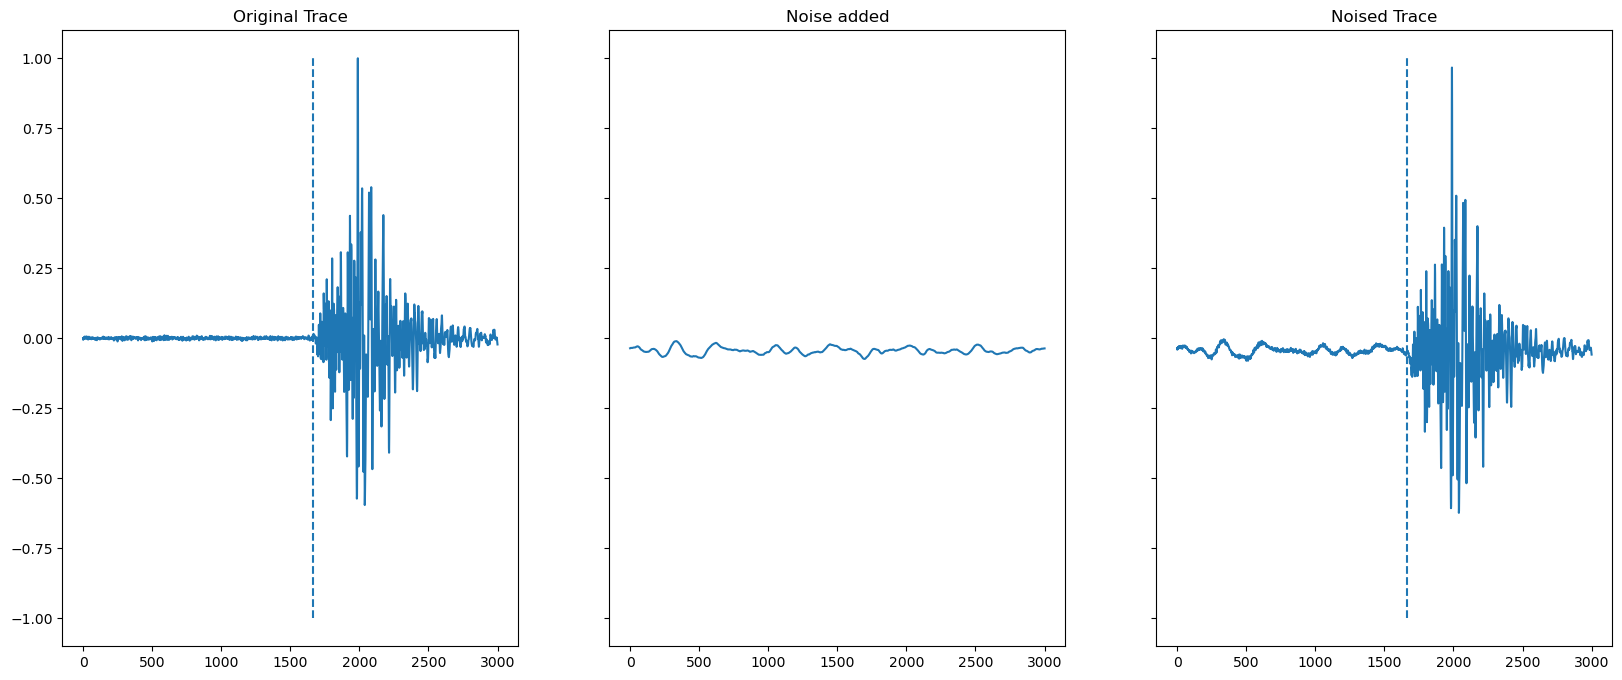

In [14]:
idx = 5
trace  = noised_traces[idx]
label  = noised_traces_labels[idx]
factor = noising_factors[idx]
noise = augmented_noise_traces[idx, :, :trace.shape[-1] ]

fig, (ax_orig,ax_noise, ax_noised) = plt.subplots(1,3,figsize=(20,8), sharey='all')

ax_orig.plot((trace - factor * noise)[0]);
ax_orig.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');
ax_orig.set_title('Original Trace')
ax_noise.plot(factor*noise[0]);
ax_noise.set_title('Noise added')
ax_noised.plot(trace[0]);
ax_noised.set_title('Noised Trace')

ax_noised.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');

## A Unified Version of The Noisy Datasets

For metrics benchmark it is preferred to create several SNR datasets using the same noises. For each SNR, a single noisy version is created.

First, prepare the noise that will be used for all SNR levels.

In [15]:
# prepare full noises traces
augmented_noise_traces_created: torch.tensor = get_n_random_noises(num_noises=num_traces, desired_window_size=AUGMENTED_WINDOW_SIZE, noises_path=NOISES_PATH, force_resample=True, filename='aaa', sampling_rate=SAMPLING_RATE, silent_exception_prints=True).squeeze()

100%|██████████| 2100/2100 [00:10<00:00, 194.62it/s]


Created a list of 2100 random noises of shape torch.Size([3, 3601])
stack to tensor
Stacked to tensor of shape torch.Size([2100, 3, 3601])


In [16]:
desired_snr_list = list(range(1,11))
noisy_dataset_paths = {}
for desired_snr in desired_snr_list:
    noisy_dataset_path = os.path.join(DATASET_PATH,f'noisy_dataset_snr_{desired_snr}')
    assert os.path.exists(noisy_dataset_path), f'Path {noisy_dataset_path} does not exist.Create it'
    noisy_dataset_paths[desired_snr] = noisy_dataset_path

pbar = tqdm(desired_snr_list)
for desired_snr in pbar:
    noised_traces, noised_traces_labels, full_noise_traces_used, factors, indices_not_used_list =  create_single_noisy_version(original_traces=dataset, original_labels=labels, augmented_noise_traces=augmented_noise_traces_created, desired_snr=desired_snr)

    indices_not_used = torch.tensor(list(set(indices_not_used_list)))
    noisy_dataset_path = noisy_dataset_paths[desired_snr]
    torch.save(noised_traces, os.path.join(noisy_dataset_path, 'traces.pt'))
    torch.save(augmented_noise_traces, os.path.join(noisy_dataset_path, 'full_noise_traces.pt'))
    torch.save(noised_traces_labels, os.path.join(noisy_dataset_path, 'labels.pt'))
    torch.save(noising_factors, os.path.join(noisy_dataset_path, 'factors.pt'))
    torch.save(indices_not_used, os.path.join(noisy_dataset_path,'indices_not_used'))
    pbar.set_description(f'SNR {desired_snr}: {noised_traces.shape[0]} noised traces created and saved.')
    del noised_traces, noised_traces_labels, full_noise_traces_used, factors, indices_not_used_list , indices_not_used

  0%|          | 0/10 [00:00<?, ?it/s]

Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:12<00:00, 166.76it/s]


Created 1892 noisy traces
The following indices are not included [19, 22, 39, 48, 67, 93, 106, 107, 113, 115, 116, 117, 118, 123, 128, 130, 131, 132, 133, 137, 141, 145, 148, 159, 193, 201, 219, 228, 253, 280, 282, 288, 300, 308, 318, 340, 353, 357, 360, 373, 378, 388, 407, 440, 451, 453, 467, 472, 492, 493, 499, 505, 511, 521, 524, 535, 556, 560, 580, 581, 588, 597, 610, 614, 617, 630, 639, 640, 651, 677, 688, 689, 695, 707, 713, 716, 738, 746, 747, 750, 764, 767, 776, 781, 846, 848, 865, 878, 882, 886, 889, 894, 902, 910, 911, 935, 949, 952, 958, 966, 984, 985, 997, 1014, 1015, 1019, 1039, 1046, 1049, 1054, 1064, 1072, 1077, 1085, 1094, 1103, 1120, 1141, 1149, 1166, 1192, 1193, 1209, 1211, 1216, 1221, 1222, 1232, 1239, 1249, 1251, 1252, 1268, 1277, 1300, 1328, 1377, 1386, 1388, 1400, 1411, 1417, 1423, 1442, 1455, 1462, 1481, 1493, 1497, 1503, 1540, 1544, 1553, 1555, 1558, 1559, 1585, 1589, 1595, 1606, 1611, 1613, 1615, 1632, 1634, 1641, 1657, 1670, 1674, 1712, 1721, 1725, 1735, 1737,


100%|██████████| 2100/2100 [00:07<00:00, 274.71it/s]


Created 2007 noisy traces
The following indices are not included [39, 48, 115, 116, 123, 130, 132, 133, 141, 148, 219, 228, 280, 282, 300, 340, 353, 360, 378, 407, 440, 451, 453, 472, 492, 493, 499, 521, 524, 580, 588, 639, 688, 713, 716, 747, 750, 776, 781, 886, 889, 910, 966, 984, 985, 997, 1014, 1015, 1019, 1039, 1054, 1064, 1094, 1103, 1141, 1222, 1232, 1239, 1251, 1252, 1277, 1328, 1400, 1411, 1442, 1481, 1497, 1503, 1540, 1553, 1558, 1606, 1611, 1615, 1634, 1641, 1712, 1725, 1735, 1754, 1810, 1820, 1823, 1825, 1845, 1852, 1904, 1972, 1976, 2033, 2043, 2071, 2079]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:05<00:00, 355.03it/s]


Created 2050 noisy traces
The following indices are not included [39, 48, 123, 130, 132, 141, 148, 219, 300, 353, 440, 451, 453, 472, 493, 499, 524, 639, 688, 747, 750, 776, 781, 886, 966, 984, 997, 1014, 1019, 1039, 1054, 1103, 1141, 1251, 1252, 1400, 1442, 1540, 1553, 1558, 1611, 1641, 1712, 1725, 1754, 1810, 1820, 1825, 1852, 2033]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:05<00:00, 408.83it/s]


Created 2076 noisy traces
The following indices are not included [48, 132, 148, 219, 300, 453, 472, 499, 639, 747, 776, 781, 966, 1019, 1103, 1251, 1442, 1540, 1641, 1725, 1754, 1820, 1852, 2033]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:04<00:00, 483.60it/s]


Created 2093 noisy traces
The following indices are not included [453, 499, 747, 781, 1251, 1540, 1852]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:04<00:00, 511.18it/s]


Created 2098 noisy traces
The following indices are not included [781, 1251]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:04<00:00, 515.59it/s]


Created 2099 noisy traces
The following indices are not included [781]
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:04<00:00, 482.55it/s]


Created 2100 noisy traces
The following indices are not included []
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:04<00:00, 493.90it/s]


Created 2100 noisy traces
The following indices are not included []
Trimmed 2100 noise traces to shape torch.Size([2100, 3, 3001])



100%|██████████| 2100/2100 [00:04<00:00, 492.77it/s]


Created 2100 noisy traces
The following indices are not included []
